# Backtesting

In time series forecasting, backtesting refers to the process of validating a predictive model using historical data. The technique involves moving backwards in time, step-by-step, to assess how well a model would have performed if it had been used to make predictions during that time period. Backtesting is a form of cross-validation that is applied to previous periods in the time series.

The purpose of backtesting is to evaluate the accuracy and effectiveness of a model and identify any potential issues or areas of improvement. By testing the model on historical data, one can assess how well it performs on data that it has not seen before. This is an important step in the modeling process, as it helps to ensure that the model is robust and reliable.

Backtesting can be done using a variety of techniques, such as simple train-test splits or more sophisticated methods like rolling windows or expanding windows. The choice of method depends on the specific needs of the analysis and the characteristics of the time series data.

Overall, backtesting is an essential step in the development of a time series forecasting model. By rigorously testing the model on historical data, one can improve its accuracy and ensure that it is effective at predicting future values of the time series.

## Backtesting with refit and increasing training size (fixed origin)

In this approach, the model is trained before making predictions each time, and all available data up to that point is used in the training process. This differs from standard cross-validation, where the data is randomly distributed between training and validation sets.

Instead of randomizing the data, this backtesting sequentially increases the size of the training set while maintaining the temporal order of the data. By doing this, the model can be tested on progressively larger amounts of historical data, providing a more accurate assessment of its predictive capabilities.

<p align="center"><img src="../img/diagram-backtesting-refit.png" style="width: 500px;"></p>

<p align="center"><img src="../img/backtesting_refit.gif" style="width: 600px;"></p>

<center><font size="2.5"> <i>Backtesting with refit and increasing training size (fixed origin).</i></font></center>

## Backtesting with refit and fixed training size (rolling origin)

In this approach, the model is trained using a fixed window of past observations, and the testing is performed on a rolling basis, where the training window is moved forward in time. The size of the training window is kept constant, allowing for the model to be tested on different sections of the data. This technique is particularly useful when there is a limited amount of data available, or when the data is non-stationary, and the model's performance may vary over time. Is also known as time series cross-validation or walk-forward validation.

<p align="center"><img src="../img/diagram-backtesting-refit-fixed-train-size.png" style="width: 500px;"></p>

<p align="center"><img src="../img/backtesting_refit_fixed_train_size.gif" style="width: 600px;"></p>

<center><font size="2.5"> <i>Backtesting with refit and fixed training size (rolling origin).</i></font></center>


## Backtesting without refit

Backtesting without refit is a strategy where the model is trained only once and used sequentially without updating it, following the temporal order of the data. This approach is advantageous as it is much faster than other methods that require retraining the model each time. However, the model may lose its predictive power over time as it does not incorporate the latest information available.

<p align="center"><img src="../img/diagram-backtesting-no-refit.png" style="width: 500px;"></p>

<p align="center"><img src="../img/backtesting_no_refit.gif" style="width: 600px;"></p>

<center><font size="2.5"> <i>Backtesting without refit.</i></font></center>

## Libraries

In [1]:
# Libraries
# ==============================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import backtesting_forecaster
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

## Data

Train dates      : 1991-07-01 00:00:00 --- 2002-01-01 00:00:00  (n=127)
Validation dates : 2002-02-01 00:00:00 --- 2008-06-01 00:00:00  (n=77)


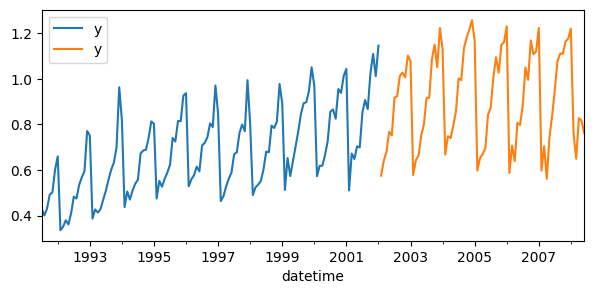

,y
datetime,
1991-07-01,0.429795
1991-08-01,0.400906
1991-09-01,0.432159
1991-10-01,0.492543


In [2]:
# Download data
# ==============================================================================
url = ('https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/data/h2o.csv')
data = pd.read_csv(url, sep=',', header=0, names=['y', 'datetime'])

# Data preprocessing
# ==============================================================================
data['datetime'] = pd.to_datetime(data['datetime'], format='%Y/%m/%d')
data = data.set_index('datetime')
data = data.asfreq('MS')
data = data[['y']]
data = data.sort_index()

# Train-validation dates
# ==============================================================================
end_train = '2002-01-01 23:59:00'

print(f"Train dates      : {data.index.min()} --- {data.loc[:end_train].index.max()}  (n={len(data.loc[:end_train])})")
print(f"Validation dates : {data.loc[end_train:].index.min()} --- {data.index.max()}  (n={len(data.loc[end_train:])})")

# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(7, 3))
data.loc[:end_train].plot(ax=ax, label='train')
data.loc[end_train:].plot(ax=ax, label='validation')
ax.legend()
plt.show()

display(data.head(4))

## Backtest

A backtesting process is applied with the following steps:

1. Train the model using the initial train size, which is specified by `initial_train_size`.

2. Use the trained model to predict the next 10 steps and save the results (`steps=10`).

3. Increase the size of the training set by adding the 10 most recent data points, while using the next 10 steps as the test data. Set refit=True to ensure that the model is retrained with the updated training set.

4. Retrain the model with the updated training set, and then use it to predict the next 10 steps.

5. Repeat steps 3 and 4 until the entire series has been tested.

By following these steps, you can ensure that the model is evaluated on multiple sets of test data, thereby providing a more accurate assessment of its predictive power. 

In [3]:
# Backtesting forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = RandomForestRegressor(random_state=123),
                 lags      = 15 
             )

metric, predictions = backtesting_forecaster(
                        forecaster         = forecaster,
                        y                  = data['y'],
                        initial_train_size = len(data.loc[:end_train]),
                        fixed_train_size   = False,
                        steps              = 10,
                        metric             = 'mean_squared_error',
                        refit              = True,
                        verbose            = True
                      )

Information of backtesting process
----------------------------------
Number of observations used for initial training: 127
Number of observations used for backtesting: 77
    Number of folds: 8
    Number of steps per fold: 10
    Last fold only includes 7 observations.

Data partition in fold: 0
    Training:   1991-07-01 00:00:00 -- 2002-01-01 00:00:00  (n=127)
    Validation: 2002-02-01 00:00:00 -- 2002-11-01 00:00:00  (n=10)
Data partition in fold: 1
    Training:   1991-07-01 00:00:00 -- 2002-11-01 00:00:00  (n=137)
    Validation: 2002-12-01 00:00:00 -- 2003-09-01 00:00:00  (n=10)
Data partition in fold: 2
    Training:   1991-07-01 00:00:00 -- 2003-09-01 00:00:00  (n=147)
    Validation: 2003-10-01 00:00:00 -- 2004-07-01 00:00:00  (n=10)
Data partition in fold: 3
    Training:   1991-07-01 00:00:00 -- 2004-07-01 00:00:00  (n=157)
    Validation: 2004-08-01 00:00:00 -- 2005-05-01 00:00:00  (n=10)
Data partition in fold: 4
    Training:   1991-07-01 00:00:00 -- 2005-05-01 00:00:0

In [4]:
print(f"Backtest error: {metric}")
predictions.head(4)

Backtest error: 0.00818535931502708


,pred
2002-02-01,0.594506
2002-03-01,0.785886
2002-04-01,0.698925
2002-05-01,0.790560


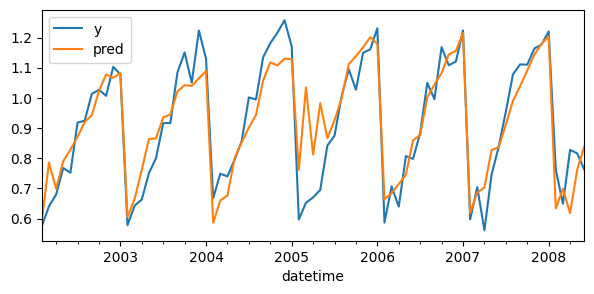

In [5]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 3))
data.loc[end_train:, 'y'].plot(ax=ax)
predictions.plot(ax=ax)
ax.legend();

## Backtesting with prediction intervals

Backtesting can be used not only to obtain point estimate predictions but also to obtain prediction intervals. Prediction intervals provide a range of values within which the actual values are expected to fall with a certain level of confidence. By estimating prediction intervals during backtesting, one can get a better understanding of the uncertainty associated with your model's predictions. This information can be used to assess the reliability of the model's predictions and to make more informed decisions. To learn more about probabilistic forecasting, visit [Probabilistic forecasting](https://joaquinamatrodrigo.github.io/skforecast/latest/user_guides/probabilistic-forecasting.html).

In [6]:
# Backtesting forecaster with prediction intervals
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = Ridge(),
                 lags      = 15 
             )

metric, predictions = backtesting_forecaster(
                            forecaster         = forecaster,
                            y                  = data['y'],
                            initial_train_size = len(data.loc[:end_train]),
                            fixed_train_size   = False,
                            steps              = 10,
                            metric             = 'mean_squared_error',
                            refit              = True,
                            interval           = [5, 95],
                            n_boot             = 500,
                            verbose            = True
                      )

Information of backtesting process
----------------------------------
Number of observations used for initial training: 127
Number of observations used for backtesting: 77
    Number of folds: 8
    Number of steps per fold: 10
    Last fold only includes 7 observations.

Data partition in fold: 0
    Training:   1991-07-01 00:00:00 -- 2002-01-01 00:00:00  (n=127)
    Validation: 2002-02-01 00:00:00 -- 2002-11-01 00:00:00  (n=10)
Data partition in fold: 1
    Training:   1991-07-01 00:00:00 -- 2002-11-01 00:00:00  (n=137)
    Validation: 2002-12-01 00:00:00 -- 2003-09-01 00:00:00  (n=10)
Data partition in fold: 2
    Training:   1991-07-01 00:00:00 -- 2003-09-01 00:00:00  (n=147)
    Validation: 2003-10-01 00:00:00 -- 2004-07-01 00:00:00  (n=10)
Data partition in fold: 3
    Training:   1991-07-01 00:00:00 -- 2004-07-01 00:00:00  (n=157)
    Validation: 2004-08-01 00:00:00 -- 2005-05-01 00:00:00  (n=10)
Data partition in fold: 4
    Training:   1991-07-01 00:00:00 -- 2005-05-01 00:00:0

In [7]:
predictions.head()

,pred,lower_bound,upper_bound
2002-02-01,0.703579,0.599636,0.834616
2002-03-01,0.673522,0.572605,0.787942
2002-04-01,0.698319,0.589196,0.815748
2002-05-01,0.703042,0.593719,0.831795
2002-06-01,0.733776,0.632476,0.842865


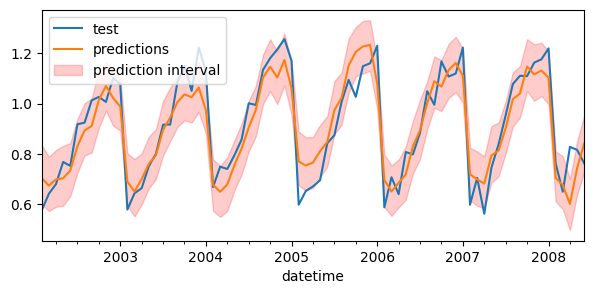

In [8]:
# Plot prediction intervals
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 3))
data.loc[end_train:, 'y'].plot(ax=ax, label='test')
predictions['pred'].plot(ax=ax, label='predictions')
ax.fill_between(
    predictions.index,
    predictions['lower_bound'],
    predictions['upper_bound'],
    color = 'red',
    alpha = 0.2,
    label = 'prediction interval'
)
ax.legend();

## Backtesting on training data

While the main focus of creating forecasting models is predicting future values, it's also useful to evaluate whether the model is learning from the training data. Predictions on the training data can help with this evaluation.

To obtain predictions on the training data,the forecaster must first be fitted using the training dataset. Then, backtesting can be performed using  `backtesting_forecaster` and specifying the arguments `initial_train_size=None` and `refit=False`. This configuration enables backtesting on the same data that was used to train the model.

In [9]:
# Create and fit forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = RandomForestRegressor(random_state=123),
                 lags      = 15 
             )

forecaster.fit(y=data['y'])

In [10]:
# Backtesting on training data
# ==============================================================================
metric, predictions_training = backtesting_forecaster(
                                    forecaster         = forecaster,
                                    y                  = data['y'],
                                    initial_train_size = None,
                                    steps              = 1,
                                    metric             = 'mean_squared_error',
                                    refit              = False,
                                    verbose            = False
                              )

print(f"Backtest training error: {metric}")

Backtest training error: 0.0005392479040738611


In [11]:
predictions_training.head(4)

,pred
1992-10-01,0.553611
1992-11-01,0.568324
1992-12-01,0.735167
1993-01-01,0.723217


It is important to note that the first 15 observations are excluded from the predictions since they are required to generate the lags that serve as predictors in the model. 

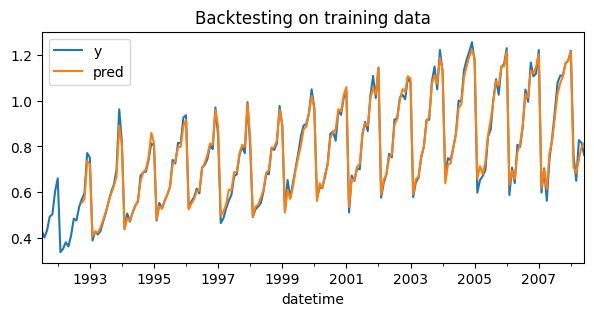

In [12]:
# Plot training predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 3))
data['y'].plot(ax=ax)
predictions_training.plot(ax=ax)
ax.set_title("Backtesting on training data")
ax.legend();

## Backtesting with custom metric

In addition to the commonly used metrics such as mean_squared_error, mean_absolute_error, and mean_absolute_percentage_error, users have the flexibility to define their own custom metric function, provided that it includes the arguments `y_true` (the true values of the series) and `y_pred` (the predicted values), and returns a numeric value (either a `float` or an `int`).

This customizability enables users to evaluate the model's predictive performance in a wide range of scenarios, such as considering only certain months, days, non holiday; or focusing only on the last step of the predicted horizon.

To illustrate this, consider the following example: a 12-month horizon is forecasted, but the interest metric is calculated by considering only the last three months of each year. This is achieved by defining a custom metric function that takes into account only the relevant months, which is then passed as an argument to the backtesting function.

In [13]:
# Backtesting with custom metric
# ==============================================================================
def custom_metric(y_true, y_pred):
    """
    Calculate the mean squared error using only the predicted values of the last
    3 months of the year.
    """
    mask = y_true.index.month.isin([10, 11, 12])
    metric = mean_squared_error(y_true[mask], y_pred[mask])
    
    return metric


metric, predictions = backtesting_forecaster(
                            forecaster         = forecaster,
                            y                  = data['y'],
                            initial_train_size = len(data.loc[:end_train]),
                            fixed_train_size   = False,
                            steps              = 10,
                            metric             = custom_metric,
                            refit              = True,
                            verbose            = False
                      )

print(f"Backtest error custom metric: {metric}")

Backtest error custom metric: 0.005580948738772139


## Backtesting with multiple metrics

The `backtesting_forecaster` function provides a convenient way to estimate multiple metrics simultaneously by accepting a list of metrics as an input argument. This list can include any combination of built-in metrics, such as mean_squared_error, mean_absolute_error, and mean_absolute_percentage_error, as well as user-defined custom metrics.

By specifying multiple metrics, users can obtain a more comprehensive evaluation of the model's predictive performance, which can help in selecting the best model for a particular task. Additionally, the ability to include custom metrics allows users to tailor the evaluation to specific use cases and domain-specific requirements.

In [14]:
metrics, predictions = backtesting_forecaster(
                            forecaster         = forecaster,
                            y                  = data['y'],
                            initial_train_size = len(data.loc[:end_train]),
                            fixed_train_size   = False,
                            steps              = 10,
                            metric             = ['mean_squared_error', 'mean_absolute_error'],
                            refit              = True,
                            verbose            = False
                       )

print(f"Backtest error metrics: {metrics}")

Backtest error metrics: [0.00818535931502708, 0.06489120319220776]


## Backtesting with exogenous variables

All the backtesting strategies discussed in this document can also be applied when incorporating exogenous variables in the forecasting model.

Exogenous variables are additional independent variables that can impact the value of the target variable being forecasted. These variables can provide valuable information to the model and improve its forecasting accuracy.

Train dates      : 1992-04-01 00:00:00 --- 2002-01-01 00:00:00  (n=118)
Validation dates : 2002-02-01 00:00:00 --- 2008-06-01 00:00:00  (n=77)


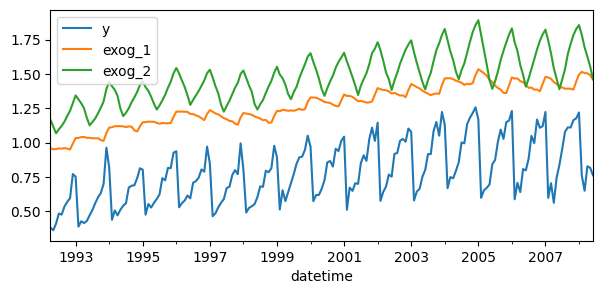

In [15]:
# Download data
# ==============================================================================
url = ('https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/data/h2o_exog.csv')
data = pd.read_csv(url, sep=',', header=0, names=['datetime', 'y', 'exog_1', 'exog_2'])

# Data preprocessing
# ==============================================================================
data['datetime'] = pd.to_datetime(data['datetime'], format='%Y/%m/%d')
data = data.set_index('datetime')
data = data.asfreq('MS')
data = data.sort_index()

# Train-validation dates
# ==============================================================================
end_train = '2002-01-01 23:59:00'

print(f"Train dates      : {data.index.min()} --- {data.loc[:end_train].index.max()}  (n={len(data.loc[:end_train])})")
print(f"Validation dates : {data.loc[end_train:].index.min()} --- {data.index.max()}  (n={len(data.loc[end_train:])})")

# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(7, 3))
data.plot(ax=ax);

In [16]:
# Backtest forecaster exogenous variables
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = RandomForestRegressor(random_state=123),
                 lags      = 15 
             )

metric, predictions = backtesting_forecaster(
                        forecaster = forecaster,
                        y          = data['y'],
                        exog       = data[['exog_1', 'exog_2']],
                        initial_train_size = len(data.loc[:end_train]),
                        fixed_train_size   = False,
                        steps      = 10,
                        metric     = 'mean_squared_error',
                        refit      = True,
                        verbose    = True
                      )

Information of backtesting process
----------------------------------
Number of observations used for initial training: 118
Number of observations used for backtesting: 77
    Number of folds: 8
    Number of steps per fold: 10
    Last fold only includes 7 observations.

Data partition in fold: 0
    Training:   1992-04-01 00:00:00 -- 2002-01-01 00:00:00  (n=118)
    Validation: 2002-02-01 00:00:00 -- 2002-11-01 00:00:00  (n=10)
Data partition in fold: 1
    Training:   1992-04-01 00:00:00 -- 2002-11-01 00:00:00  (n=128)
    Validation: 2002-12-01 00:00:00 -- 2003-09-01 00:00:00  (n=10)
Data partition in fold: 2
    Training:   1992-04-01 00:00:00 -- 2003-09-01 00:00:00  (n=138)
    Validation: 2003-10-01 00:00:00 -- 2004-07-01 00:00:00  (n=10)
Data partition in fold: 3
    Training:   1992-04-01 00:00:00 -- 2004-07-01 00:00:00  (n=148)
    Validation: 2004-08-01 00:00:00 -- 2005-05-01 00:00:00  (n=10)
Data partition in fold: 4
    Training:   1992-04-01 00:00:00 -- 2005-05-01 00:00:0

In [17]:
print(f"Backtest error with exogenous variables: {metric}")

Backtest error with exogenous variables: 0.007800037462113706


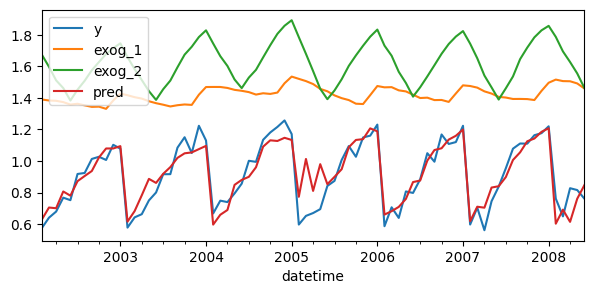

In [18]:
fig, ax = plt.subplots(figsize=(7, 3))
data.loc[end_train:].plot(ax=ax)
predictions.plot(ax=ax)
ax.legend(loc="upper left");

In [19]:
%%html
<style>
.jupyter-wrapper .jp-CodeCell .jp-Cell-inputWrapper .jp-InputPrompt {display: none;}
</style>